In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize
from dataclasses import dataclass
import os
import numpy as np

from sample4geo.dataset.soundingearth import SoundingEarthDatasetEval, SoundingEarthDatasetTrain
from torch.utils.data import DataLoader
from sample4geo.transforms import get_transforms_train_sat, get_transforms_train_spectro 
from sample4geo.transforms import get_transforms_val_sat, get_transforms_val_spectro 



@dataclass
class Configuration:
    img_size: int = 384         # for satallite images
    patch_time_steps = 1024      # Image size for spectograms (Width)
    n_mels = 128                # image size for spectograms (Height)
    sr_kHz=48
    batch_size: int = 32         # keep in mind real_batch_size = 2 * batch_size
    data_folder = "data/SoundingEarth/data"   # Dataset
    # Augment Images
    prob_rotate: float = 0.75          # rotates the sat image 
    prob_flip: float = 0.5             # flipping the sat image 
    num_workers: int = 0 if os.name == 'nt' else 4 
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu' 
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    

config = Configuration()

img_size = config.img_size
img_size_sat = (img_size, img_size)
img_size_spectro = (config.patch_time_steps, config.n_mels)

# Transforms
sat_transforms_train = get_transforms_train_sat(img_size_sat,
                                                    mean=config.mean,
                                                    std=config.std,
                                                    )

spectro_transforms_train = get_transforms_train_spectro(img_size_spectro,
                                                                mean=config.mean,
                                                                std=config.std,
                                                                )


train_dataset = SoundingEarthDatasetTrain(data_folder=config.data_folder ,
                                          split_csv='train_df.csv',
                                          transforms_sat_image=sat_transforms_train,
                                          transforms_spectrogram=spectro_transforms_train,
                                          patch_time_steps=config.patch_time_steps,
                                          sr_kHz=config.sr_kHz,
                                          n_mels=config.n_mels,
                                          prob_flip=config.prob_flip,
                                          prob_rotate=config.prob_rotate,
                                          shuffle_batch_size=config.batch_size
                                          )


train_dataloader = DataLoader(train_dataset,
                              batch_size=12,  
                              shuffle=True,
                              num_workers=config.num_workers,
                              pin_memory=True)

sat_transforms_val = get_transforms_val_sat(img_size_sat,
                                                mean=config.mean,
                                                std=config.std,
                                                )

spectro_transforms_val = get_transforms_val_spectro(img_size_spectro,
                                                        mean=config.mean,
                                                        std=config.std,
                                                        )
# Eval
eval_dataset = SoundingEarthDatasetTrain(data_folder=config.data_folder ,  # using train as eval
                                          split_csv='test_df.csv',
                                          transforms_sat_image=sat_transforms_val,
                                          transforms_spectrogram=None,
                                          patch_time_steps=config.patch_time_steps,
                                          sr_kHz=config.sr_kHz,
                                          n_mels=config.n_mels,
                                          prob_flip=0,
                                          prob_rotate=0,
                                          shuffle_batch_size=config.batch_size
                                          )

eval_dataloader = DataLoader(eval_dataset,
                              batch_size=12,  
                              shuffle=True,
                              num_workers=config.num_workers,
                              pin_memory=True)
    

/home/j0kr0017/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/j0kr0017/conda/lib/python3.12/site-packages/pydantic/main.py:328: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Plotte Train Dataloader Bilder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


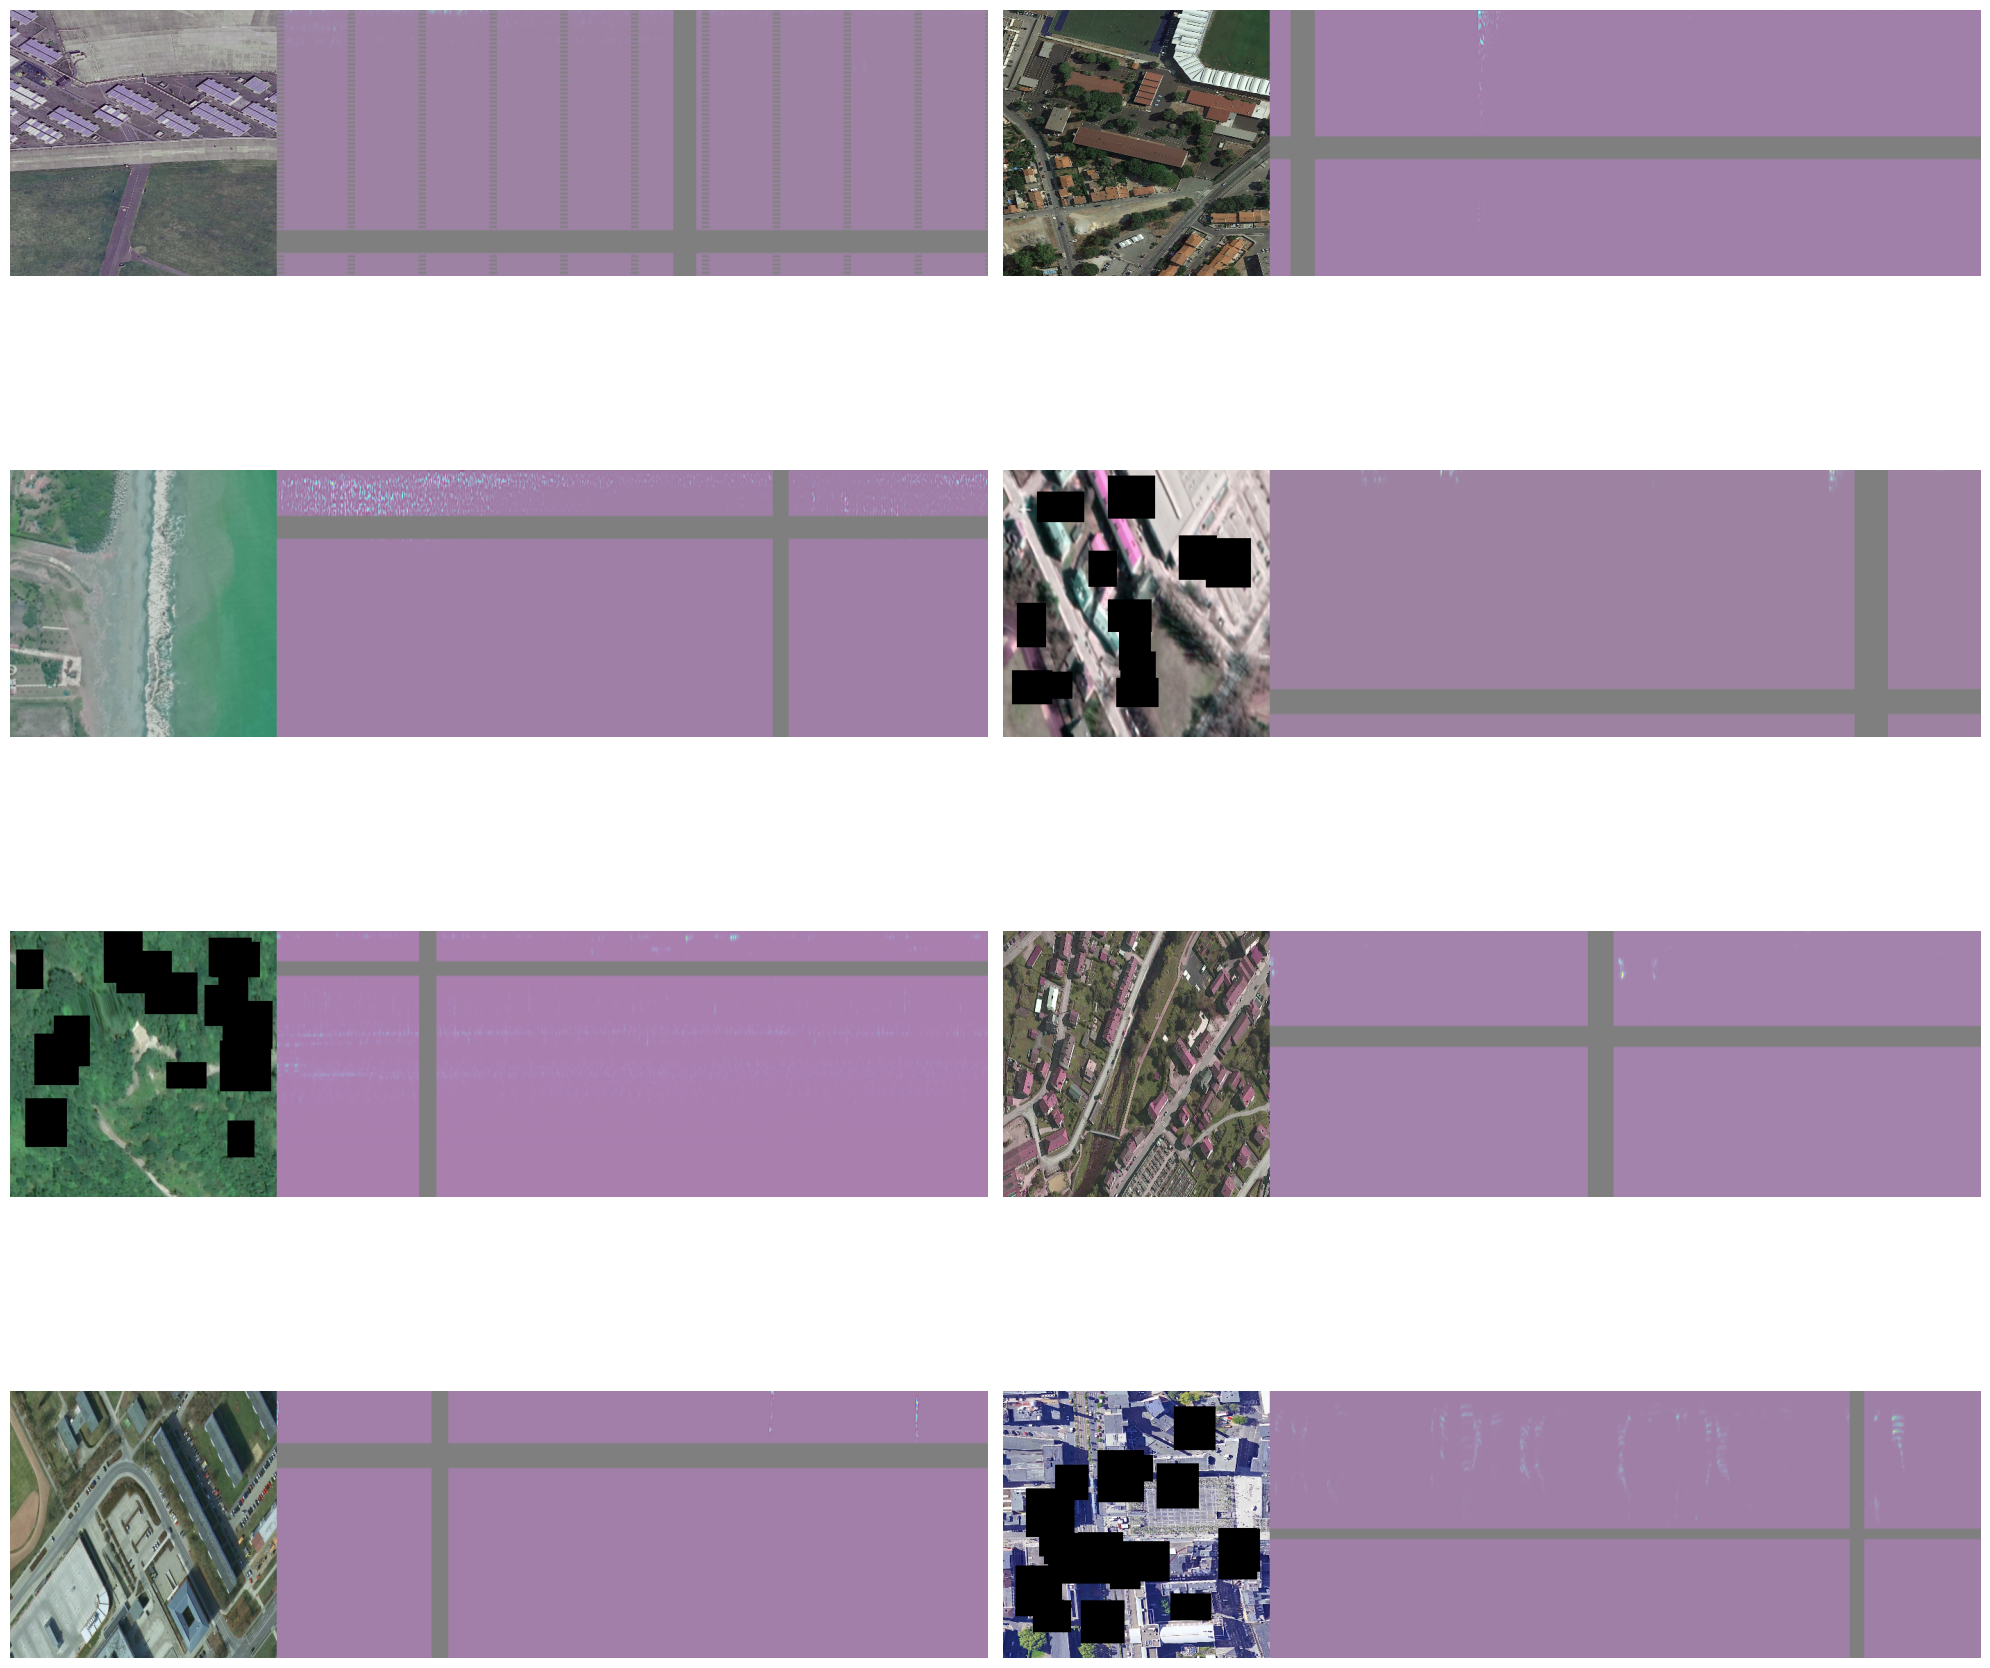

In [2]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_images(dataloader, num_images,  spectro_den_b = True, sat_den_b = True):
    num_rows = (num_images + 1) // 2  
    fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 5 * num_rows))  
    axs = axs.flatten() 

    image_count = 0
    for data in dataloader:
        sat_images, spectrograms, _ = data  

        for sat_image, spectrogram in zip(sat_images, spectrograms):
            if image_count >= num_images:
                break

            if sat_den_b:
                sat_image = denormalize(sat_image, config.mean, config.std)
            if spectro_den_b:
                spectrogram = denormalize(spectrogram, config.mean, config.std)
                #spectrogram = (spectrogram + )    # to convert 

            target_height = sat_image.shape[1]  
            spectrogram_resized = resize(spectrogram, (target_height, spectrogram.shape[-1]))

            combined_image = torch.cat((sat_image, spectrogram_resized), dim=2)  

            ax = axs[image_count]
            ax.imshow(combined_image.permute(1, 2, 0).numpy())  
            ax.axis('off')  
            image_count += 1

        if image_count >= num_images:
            break

    plt.tight_layout()
    plt.show()

plot_images(train_dataloader, 8, spectro_den_b = False, sat_den_b = True)

Plotte Eval Dataloader Bilder

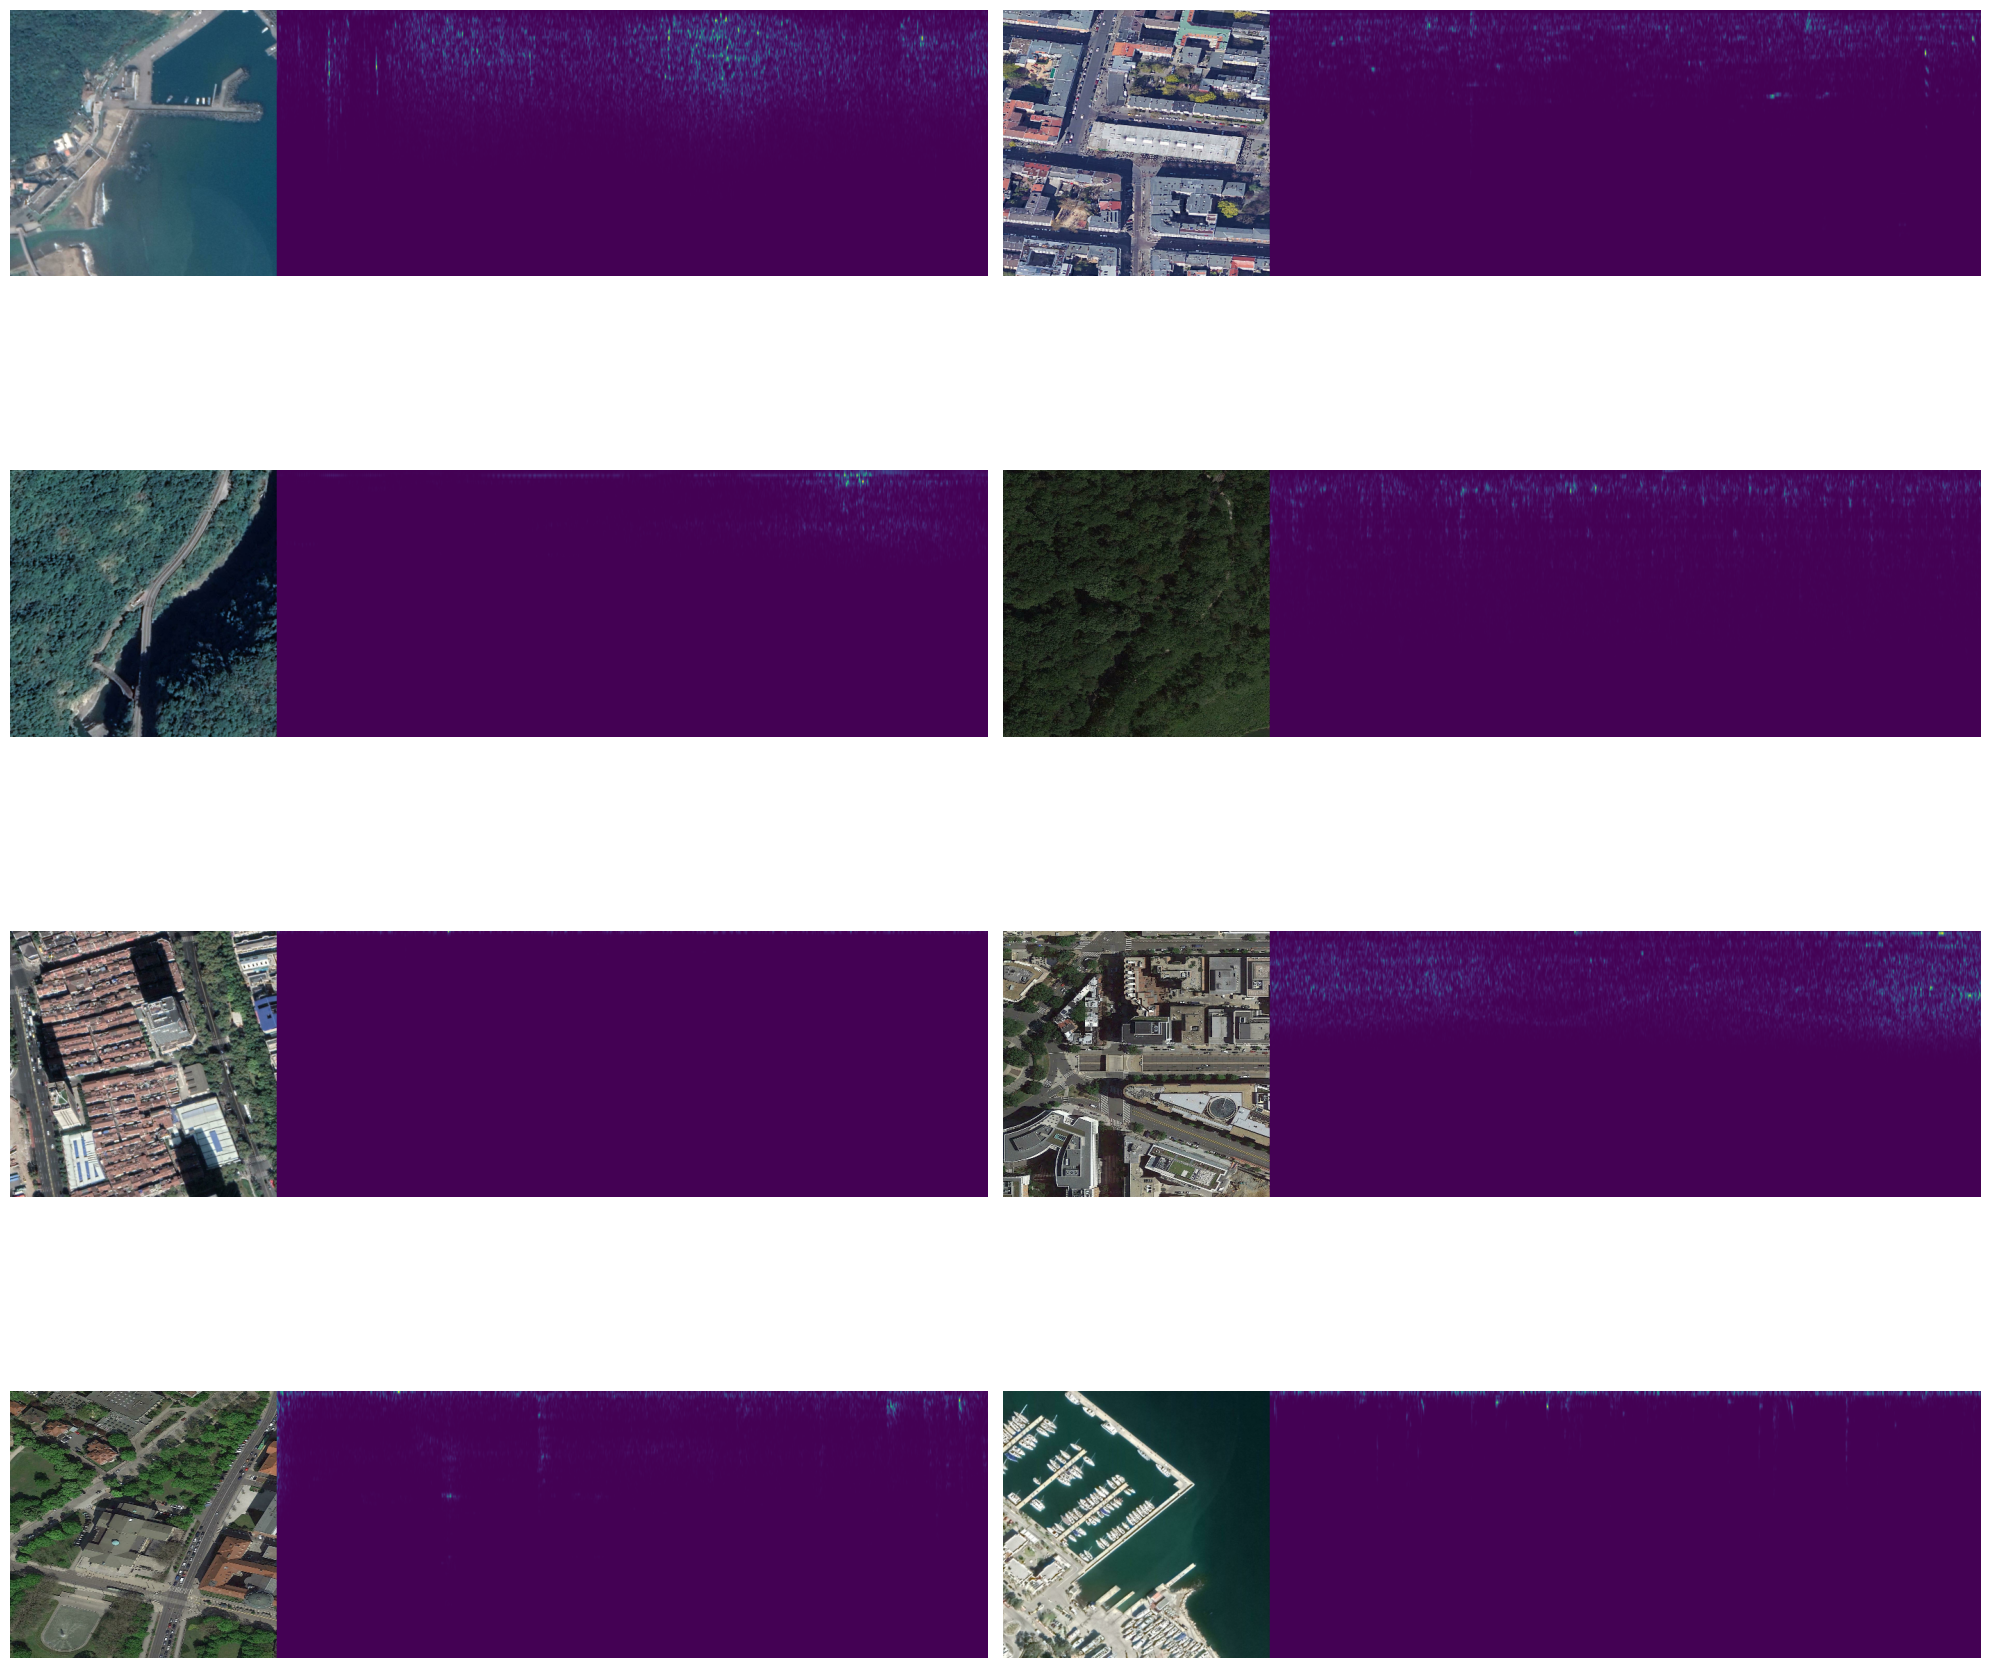

In [3]:
plot_images(eval_dataloader, 8,  spectro_den_b = False, sat_den_b = True)